In [42]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 

%reload_ext autoreload
%aimport Funcs
%aimport fluid_flow
%aimport parameters
from Funcs import advance_adv_diff_RK3, advance_adv_diff_RK4
from fluid_flow import advance_fluid_flow, set_boundary, dt_fluid_flow
from pathlib import Path
from parameters import * # <-- dangerous; make sure to put only global constants in that file
N = 100
dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,N)
dt = dt_fluid_flow(dx, Fo=0.3)
dt

8.162432404856647e-06

# Visulizing FluidFlow

1. Simulation

In [43]:
from Funcs import metric_L0, metric_RMS
from math import sin, pi, exp
from poisson_solver import get_atol
import time
dt = dt_fluid_flow(dx, Fo=0.3)
u0 = np.zeros((N,N))
v0 = np.copy(u0)
u0,v0 = set_boundary(u0,v0,Ns_c, Nc_lw)
u, v = np.copy(u0), np.copy(v0)
amax     = 1e-4 # initial value for atol at t=0
amin     = 1e-8 # value at tmax
tmax     = 0.01 # atol = amax for t > tmax
w = 2 / (1 + sin(pi/N))
N_loop = 360
t = 0.015
dt_measure = t / N_loop
Nt = int(dt_measure / dt)
n_conv_check = int(np.round(8.9e-5/dt))
Nt0=1
u, v, P = advance_fluid_flow(Nt0, u, v, advance_adv_diff_RK3, dt)[:3]
t0 = time.time()
# convergence analysis:
U=[u]
V=[v]
Pr=[P]
for i in range(N_loop):
    
    t = i * dt * Nt + dt * Nt0 
    atol = get_atol(t, amin, amax, tmax)    
    u, v, P = advance_fluid_flow(Nt, u, v, advance_adv_diff_RK3, dt, w=w, atol=atol, P=P, n_conv_check=n_conv_check)[:3]
    if i==3000:
        plt.imshow(u.T**2+v.T**2)
    U .append(u.copy())
    V .append(v.copy())
    Pr.append(P.copy())
print('CPU time [s]: ', time.time() - t0)
plt.show()

CPU time [s]:  26.33992290496826


2. Data Saving

In [45]:
U=np.array(U)
V=np.array(V)
Pr=np.array(Pr)
if True:
    p = Path('data/vel_field/data_cube/') / 'UVP_cube_N_{}_Leap_{}_dt_{}.npy'.format(N,N_loop,dt)
    np.save(p, np.array([U,V,P]))
if False:
    p = Path('data/vel_field/data_cube/') / 'UVP_cube_N_{}_Leap_{}_dt_{}.npy'.format(N,N_loop,dt)
    U,V,P=np.load(p)
dt


8.162432404856647e-06

3. Visulization

(361, 100, 100)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
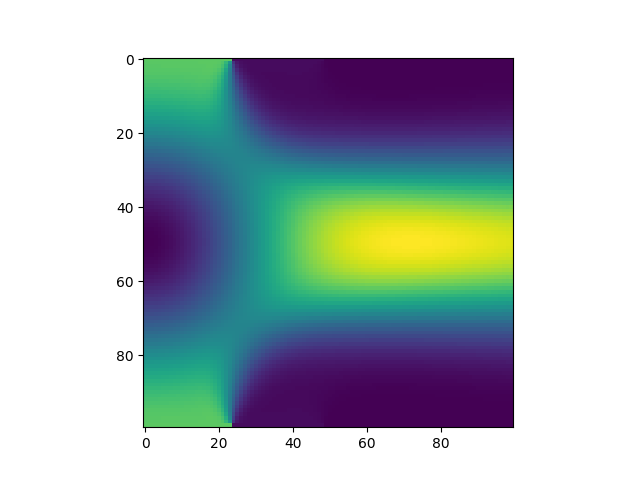

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
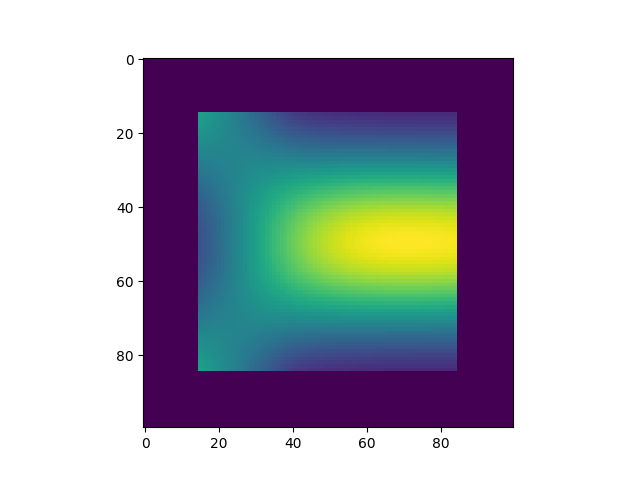

In [79]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
def update(frame):
    # ln[1].set_data(V[frame].T**2+U[frame].T**2)
    N_leap=1
    ln[0].set_UVC(U_reduced[frame*N_leap].T, V_reduced[frame*N_leap].T)
    ln[1].set_array(V[frame*N_leap].T**2+U[frame*N_leap].T**2)
    ln[2].set_array(Pr[frame*N_leap].T)
    ln3.set_clim(vmin=0,vmax=np.max(Pr[frame*N_leap]))
    ln[3].set_text('${:06.3f}ms$'.format(frame*N_leap*dt*10**3))
    if frame*N_leap%20==0:  
        print(frame*N_leap,frame*N_leap%100) 
    #  cbar2 = fig.colorbar(ln3, cax=cax)
    return ln
# Ut=U.copy()
# Vt=V.copy()
# Pt=Pr.copy()

@jit(nopython=True)
def reduce_matrix(Mat,a):
    """
    Fast way to reduce matrix resolution to solve dense quiver field
    Reduces the Velocity field components
    """
    Mat_2 = np.zeros_like(Mat)
    N = Mat.shape[0]
    MID = 1
    ADJ = 1
    DIA = 1
    SAM = 0
    for x in range(a,N-a):
        for y in range(a,N-a):
            i = 0
            for x2 in range(-a,a+1):
                for y2 in range(-a,a+1):
                    if x+x2<N and y2+y<N:
                        if x2==0 and y2 ==0:
                            i+=MID
                            Mat_2[x,y] += MID * Mat[x+x2,y+y2]
                        elif x2 == 0 or y2 == 0:
                            i+=ADJ
                            Mat_2[x,y] += ADJ * Mat[x+x2,y+y2]
                        else:
                            i+=DIA
                            Mat_2[x,y] += DIA *Mat[x+x2,y+y2] 
                        
            Mat_2[x,y]/=i
            

    return Mat_2
i = -1
print(U.shape)
plt.figure()
plt.imshow(U[i].T**2+V[i].T**2)
plt.show()
plt.figure()
plt.imshow(reduce_matrix (U[i].T**2+V[i].T**2,15))
plt.show()

<ipython-input-92-3b09a68956f1>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ln2  = ax.pcolormesh(x,y,U[0].T**2+V[0].T**2,


0 0
0 0
20 20
40 40
60 60
80 80
100 0
120 20
140 40
160 60
180 80
200 0
220 20
240 40
260 60
280 80
300 0
320 20
340 40
360 60


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
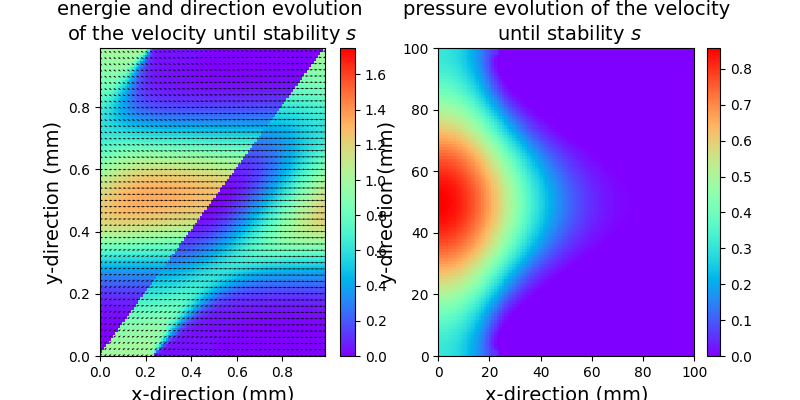

In [92]:
U_reduced = np.array([reduce_matrix(U [i],int((len(U [i])-50)/2))[int(len(U[i])/2-25):int(len(U[i])/2+25),int(len(U[i])/2-25):int(len(U[i])/2+25)] for i in range(len(U))])
V_reduced = np.array([reduce_matrix(V [i],int((len(V [i])-50)/2))[int(len(V[i])/2-25):int(len(V[i])/2+25),int(len(V[i])/2-25):int(len(V[i])/2+25)] for i in range(len(U))])
P_reduced = np.array([reduce_matrix(Pr[i],int((len(Pr[i])-50)/2))[int(len(Pr[i])/2-25):int(len(Pr[i])/2+25),int(len(Pr[i])/2-25):int(len(Pr[i])/2+25)] for i in range(len(U))])

fig, (ax,ax2) = plt.subplots(1,2,figsize=(32/4,16/4))
fontsize=14
ln1  = ax.quiver(np.arange(0,1,step=1/50),
                 np.arange(0,1,step=1/50),
                 U_reduced[0].T   ,
                 V_reduced[0].T   ,scale=40,zorder=2)

x, y = np.meshgrid(np.arange(0, 1, 1/U[0].shape[0]), 
                   np.arange(0, 1, 1/U[0].shape[1]))

ln2  = ax.pcolormesh(x,y,U[0].T**2+V[0].T**2,
                     zorder=1,vmin=0,vmax=1.75,cmap='rainbow')
ln3  = ax2.pcolormesh(Pr[0].T           ,zorder=1,                 cmap='rainbow')
txt = ax.text(25,25,'$0\\mu s$',zorder=3,fontsize = fontsize)
# ax .set_xticklabels(ax .get_xticks()/N)
# ax .set_yticklabels(ax .get_yticks()/N)
# ax2.set_xticklabels(ax2.get_xticks()/N)
# ax2.set_yticklabels(ax2.get_yticks()/N)

cbar  = fig.colorbar(ln2,ax=ax )
div = make_axes_locatable(ax2)
cax = div.append_axes('right', '5%', '5%')
cbar2 = fig.colorbar(ln3, cax=cax)


ln = [ln1,ln2,ln3,txt]

ax .set_title("energie and direction evolution \nof the velocity until stability $s$",fontsize = fontsize)
ax .set_ylabel('y-direction (mm)',fontsize = fontsize)
ax .set_xlabel('x-direction (mm)',fontsize = fontsize)
ax2.set_title("pressure evolution of the velocity\n until stability $s$",fontsize = fontsize)
ax2.set_ylabel('y-direction (mm)',fontsize = fontsize)
ax2.set_xlabel('x-direction (mm)',fontsize = fontsize)
plt.rcParams['animation.ffmpeg_path'] = r"C:\ffmpeg-2021-10-18-git-d04c005021-full_build\bin\ffmpeg.exe"
writer = animation.writers['ffmpeg']
writer = writer(fps=60, metadata=dict(artist='Slimane MZERGUAT'), bitrate=1800)
ani = FuncAnimation(fig, update, blit=True, frames=int(len(U)),interval=200,repeat=False)#int(len(U)/50)
ani.save("res.mp4", writer=writer)
plt.show()


In [90]:
x.shape

NameError: name 'x' is not defined

# Pre-combustion

In [63]:
%matplotlib widget
# %matplotlib notebook doesn't work on vscode

import matplotlib.pyplot as plt
import numpy as np 
from numba import jit
from numpy import sin, pi
from pathlib import Path

%reload_ext autoreload
%aimport Funcs
%aimport visualization
%aimport species_transport
%aimport parameters
from parameters import *
from fluid_flow import dt_fluid_flow
from species_transport import set_BCs, set_Temp_BC, evolve_species
N = 50
M=N
dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,M)
dt = dt_fluid_flow(dx, Fo=0.3)
datap = Path('data/vel_field/test0') / 'UVP_N{}.npy'.format(N)
u,v,_ = np.load(datap)
# initial setup of the species distribution
CH4, O2, N2, H2O, CO2, T = np.zeros((6,N,M))
O2[:] = .233
N2[:] = .767
T[:] = 300
Y = np.array([CH4, O2, N2, CO2, H2O])

In [64]:
Nt0 = 1
t = 0.05
dt_measure = t / 360
Nt = int(dt_measure / dt)
N_loop = int(t / dt_measure)
Y_cube=[Y]
# initial warm-up:
Y, T = evolve_species(Nt0, Y, T, dt, u, v, dx, dy, Ns_c, Nc_lw, chem=False, evolve_T=False)
t0 = time.time()
for i in range(N_loop):
    t = i * dt * Nt + dt * Nt0 
    Y, T = evolve_species(Nt, Y, T, dt, u, v, dx, dy, Ns_c, Nc_lw, chem=False, evolve_T=False)
    Y_cube.append(Y)
print('CPU time [s]: ', time.time() - t0)

CPU time [s]:  1.5440003871917725


5


AttributeError: 'list' object has no attribute 'flatten'

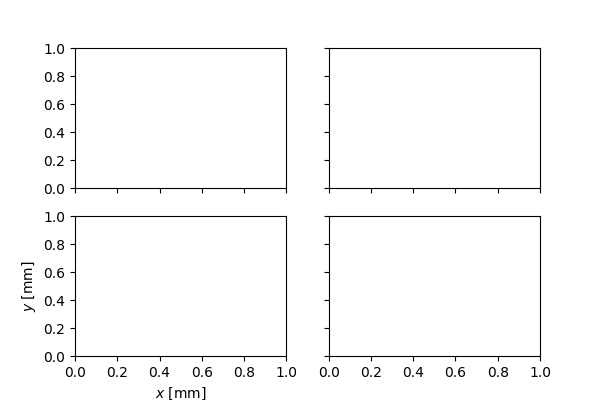

In [72]:
from species_transport import species_names_2
i = 0
fig, axs = plt.subplots(2, 2, figsize=(6,4.),sharex=True, sharey=True)
nsp = Y_cube[i].shape[0]
print(nsp)
axs[-1,0].set_xlabel('$x$ [mm]')
axs[-1,0].set_ylabel('$y$ [mm]')
axs = axs.flatten()
for k in np.arange(nsp):
    dat = Y_cube[i][k].T
    title = 'Y_{' + species_names_2[k] + '}'
    title = r'${}$'.format(title)
    vmin, vmax=0,1
    cmap = 'seismic'

    im = axs[k].imshow(dat, cmap=cmap, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, extent=(0,Lx*1e3,0,Ly*1e3))
    axs[k].set_title(title)
    if k==2:
        fig.colorbar(im, ax=axs[k], label='$Y_k$')
    elif k==nsp:
        fig.colorbar(im, ax=axs[k], label='$T$ [K]')

            
    #fig.suptitle(r'Mass fractions $Y_k$ of species $k$ / temperature $T$')
    plt.tight_layout()




















# U = Ut[:int(len(Ut)/10)].copy()
# V = Vt[:int(len(Ut)/10)].copy()
# Pr = Pt[:int(len(Ut)/10)].copy()
# print(len(U))
# fig, (ax,ax2) = plt.subplots(1,2,figsize=(32,16))
# fontsize=14
# ln1  = ax.quiver(U[0].T   ,V[0].T   ,scale=40,zorder=2)
# ln2  = ax.pcolormesh(U[0].T**2+V[0].T**2,zorder=1,vmin=0,vmax=1.75,cmap='rainbow')
# ln3  = ax2.pcolormesh(Pr[0].T           ,zorder=1,                 cmap='rainbow')
# txt = ax.text(25,25,'$0\\mu s$',zorder=3,fontsize = fontsize)
# ax .set_xticklabels(ax .get_xticks()/N)
# ax .set_yticklabels(ax .get_yticks()/N)
# ax2.set_xticklabels(ax2.get_xticks()/N)
# ax2.set_yticklabels(ax2.get_yticks()/N)

# cbar  = fig.colorbar(ln2,ax=ax )
# div = make_axes_locatable(ax2)
# cax = div.append_axes('right', '5%', '5%')
# cbar2 = fig.colorbar(ln3, cax=cax)


# ln = [ln1,ln2,ln3,txt]

# ax .set_title("energie and direction evolution \nof the velocity until stability$ \\mu s$",fontsize = fontsize)
# ax .set_ylabel('y-direction (mm)',fontsize = fontsize)
# ax .set_xlabel('x-direction (mm)',fontsize = fontsize)
# ax2.set_title("pressure evolution of the velocity\n until stability$ \\mu s$",fontsize = fontsize)
# ax2.set_ylabel('y-direction (mm)',fontsize = fontsize)
# ax2.set_xlabel('x-direction (mm)',fontsize = fontsize)
# plt.rcParams['animation.ffmpeg_path'] = r"C:\Users\hp\Documents\ffmpeg-2021-10-18-git-d04c005021-full_build\bin\ffmpeg.exe"
# writer = animation.writers['ffmpeg']
# writer = writer(fps=60, metadata=dict(artist='Slimane MZERGUAT'), bitrate=1800)
# ani = FuncAnimation(fig, update, blit=True, frames=int(len(U)/1),interval=200,repeat=False)#int(len(U)/50)
# ani.save("res.mp4", writer=writer)
# plt.show()
